In [1]:
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
%matplotlib notebook

from tqdm import tqdm

# Data Dictionary

#### orders (415k rows): fact table, one record per order, includes useful time dimensions
- order_id: order identifier
- user_id: customer identifier
- order_number: the order sequence number for this user (1 = first, n = nth)
- order_dow: the day of the week the order was placed on
- Order_hour_of_day: hour of day the order was placed
- Days_since_prior_order: Number of days since that customer placed their previous order (NA for order_number = 1)

#### order_products (3.9M rows): fact table, one record per order, per product
_except for last order by a customer_
- order_id: foreign key
- product_id: foreign key
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

#### products (50k rows): Dimension table for product info
- product_id: product identifier
- product_name: name of the product
- aisle_id: foreign key
- department_id: foreign key

#### aisles (134 rows): Dimension table for aisle info
- aisle_id: aisle identifier
- aisle: the name of the aisle

#### departments (21 rows): Dimension table for department info
- department_id: department identifier
- department: the name of the department


In [2]:
engine = sql.create_engine('sqlite:///instacart.db')
db = {}

In [3]:
for table in ['orders', 'order_products', 'products', 'aisles', 'departments',]:
    db[table] = pd.read_sql_table(table, engine, index_col=0,)

In [4]:
# aliases
orders = db['orders']
orders.set_index('order_id', inplace=True)

ops = db['order_products']   # default index vs. multi-index on order_id + add_to_cart_order

products = db['products']
del(products['index'])       # index is one off from xxxx_id, confusing
products.set_index('product_id', inplace=True)

del(db['departments']['index'])
db['departments'].set_index('department_id', inplace=True)

del(db['aisles']['index'])
db['aisles'].set_index('aisle_id', inplace=True)

In [5]:
from collections import defaultdict

depts = defaultdict(set)
aisles = {}
for aisle in db['aisles'].index:
    aisle_products = products[products.aisle_id == aisle]['department_id']
    for product_dept in aisle_products:
        depts[int(product_dept)].add(int(aisle))
        aisles[int(aisle)] = int(product_dept)

In [7]:
dept = 1
print(db['departments'].department[dept] + '\n')

for aisle in depts[dept]:
    print(db['aisles'].aisle[aisle])

frozen

frozen appetizers sides
frozen meat seafood
ice cream ice
frozen meals
frozen vegan vegetarian
frozen pizza
frozen juice
frozen breakfast
frozen produce
frozen dessert
frozen breads doughs


In [8]:
orders.count()

user_id                   414772
order_number              414772
order_dow                 414772
order_hour_of_day         414772
days_since_prior_order    389772
dtype: int64

In [9]:
len(db['order_products']['order_id'].unique())

389772

In [10]:
orders[orders['user_id'] == 2]

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,
2168274,2,1,2,11,NaN
1501582,2,2,5,10,10.0
1901567,2,3,1,10,3.0
738281,2,4,2,10,8.0
1673511,2,5,3,11,8.0
1199898,2,6,2,9,13.0
3194192,2,7,2,12,14.0
788338,2,8,1,15,27.0
1718559,2,9,2,9,8.0


In [11]:
db['order_products'][ops['order_id'] == 1492625]  # last order by customer no. 2

,order_id,product_id,add_to_cart_order,reordered


# Analysis:

## Note on data:
Order_products does not include the last order by any customer

## Topics

Breakdowns by:

1. Product (most popular, least)
2. Departments ( -> Aisles)
3. Customers:
- best: what is predictive in first order of repeat customers
- worst: what is predictive in first order of single-visit customers
4. Timing (week, day)
5. Item order: what % of times that a product is ordered is it the first item ordered? i.e. types of items that are top-of mind
6. Products: what are predictions for next product added to cart? Could we increase sales by showing this item?


# 0. A quick look at what the data is

Text(0.5,0,'order size (items)')

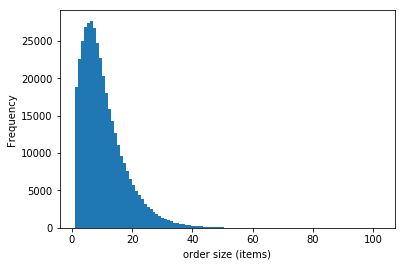

In [13]:
ax = ops.groupby('order_id').size().plot.hist(bins=102)
ax.set_xlabel('order size (items)')

Text(0.5,0,'number of orders per customer')

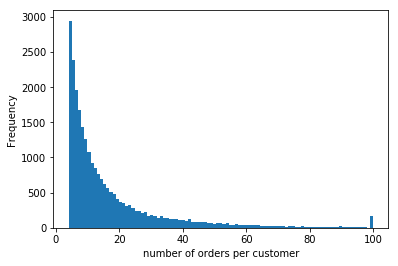

In [14]:
ax = orders.groupby('user_id').size().plot.hist(bins=97) # long tail accumulates at 100
ax.set_xlabel('number of orders per customer')

In [122]:
ops.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')

In [130]:
times_product_ordered = pd.DataFrame({'times_ordered': ops.groupby('product_id').size()})

In [21]:
orders['order_id'] = orders.index
user_orders = orders.groupby('user_id')['order_id'].unique()  # DF of order_id for each user

In [152]:
times_product_ordered = times_product_ordered.join(db['products']).sort_values('times_ordered', ascending=False)

In [170]:
times_product_ordered['log_times'] = times_product_ordered.times_ordered.apply(pd.np.log10)

In [175]:
times_product_ordered[:20]

,times_ordered,product_name,aisle_id,department_id,log_times
product_id,,,,,
24852,58231,Banana,24,4,4.765154
13176,45699,Bag of Organic Bananas,24,4,4.659907
21137,32203,Organic Strawberries,24,4,4.507896
21903,29380,Organic Baby Spinach,123,4,4.468052
47209,25958,Organic Hass Avocado,24,4,4.414271
47766,21642,Organic Avocado,24,4,4.335297
47626,18581,Large Lemon,24,4,4.269069
26209,17399,Limes,24,4,4.240524
16797,17217,Strawberries,24,4,4.235957


In [180]:
times_product_ordered.times_ordered[:10].sum()  # 10 (of 50k) products are 8% of order items

282778

In [177]:
times_product_ordered.times_ordered[:100].sum()  # 100 (of 50k) products are 25% of order items

907927

In [179]:
times_product_ordered.times_ordered[:1000].sum()  # 1000 (of 50k) products are 50% of order items

2130720

In [181]:
times_product_ordered.times_ordered[:10000].sum()  # 10000 (of 50k) products are 90% of order items

3587270

In [283]:
times_product_ordered.index

Int64Index([24852, 13176, 21137, 21903, 47209, 47766, 47626, 26209, 16797,
            27845,
            ...
             9586,  2988, 30870, 24947,  9589, 15500, 19466, 41731,  7302,
             4468],
           dtype='int64', name='product_id', length=42814)

In [241]:
times_product_ordered[times_product_ordered.times_ordered.isin([1, 2])].count()

times_ordered    9301
product_name     9301
aisle_id         9301
department_id    9301
log_times        9301
dtype: int64

In [284]:
times_product_ordered['reorder_pct'] = ops.groupby('product_id').mean().reordered

In [294]:
%matplotlib

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


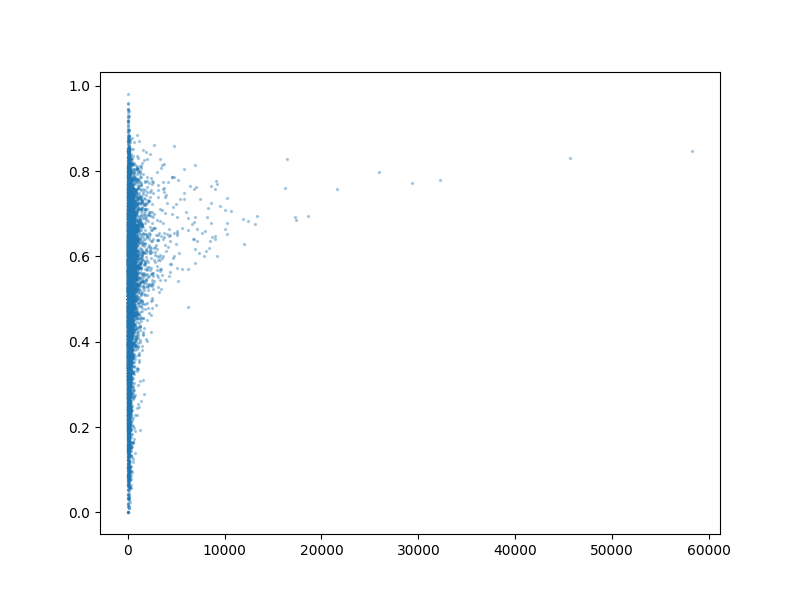

In [299]:
plt.figure(figsize=(8,6))
plt.scatter(times_product_ordered.times_ordered[:10000], times_product_ordered.reorder_pct[:10000], s=2, alpha=.3)

In [301]:
times_product_ordered[times_product_ordered.times_ordered < 6500][:10]    # olive oil is the outlier... reasonable

,times_ordered,product_name,aisle_id,department_id,log_times,reorder_pct
product_id,,,,,,
24838,6418,Unsweetened Almondmilk,91,16,3.807400,0.764101
25890,6236,Boneless Skinless Chicken Breasts,49,12,3.794906,0.662765
31506,6230,Extra Virgin Olive Oil,19,13,3.794488,0.480738
46667,6218,Organic Ginger Root,83,4,3.793651,0.570601
22825,6199,Organic D'Anjou Pears,24,4,3.792322,0.690595
39928,6044,Organic Kiwi,24,4,3.781324,0.703342
35221,5803,Lime Sparkling Water,115,7,3.763653,0.748578
12341,5796,Hass Avocados,32,4,3.763128,0.734990
5785,5777,Organic Reduced Fat 2% Milk,84,16,3.761702,0.805262


In [308]:
times_product_ordered.groupby('aisle_id').sum().join(db['aisles']).sort_values('times_ordered', ascending=False)

,times_ordered,department_id,log_times,reorder_pct,aisle
aisle_id,,,,,
24,443180,1412,643.944270,138.558367,fresh fruits
83,416040,2180,1018.379744,203.471749,fresh vegetables
123,214421,2292,886.476042,231.595918,packaged vegetables fruits
120,176682,14928,1466.843277,491.884997,yogurt
21,117396,13216,1124.070022,317.536635,packaged cheese
84,109584,3584,414.005084,132.488978,milk
115,102840,2163,496.982525,164.806177,water seltzer sparkling water
107,88132,16682,1151.575281,365.728441,chips pretzels
91,77567,4416,452.140322,139.804993,soy lactosefree


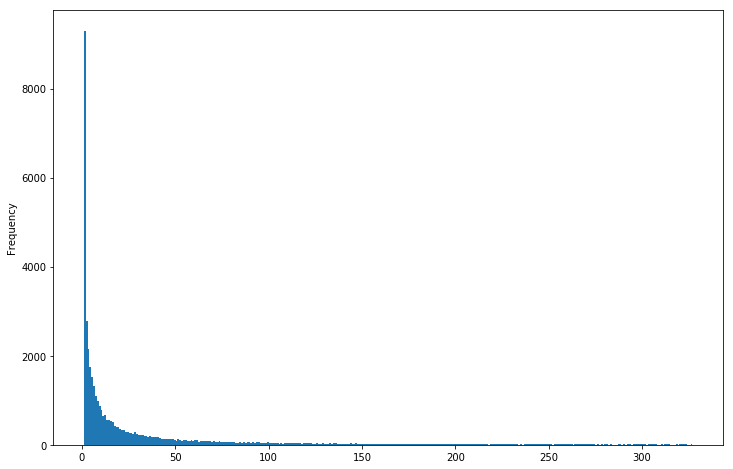

In [247]:
plt.figure(figsize=(12, 8))
times_product_ordered.times_ordered[-40700:].plot.hist(bins=325)

In [268]:
dept_orders = pd.DataFrame({'times_ordered': times_product_ordered.groupby('department_id').times_ordered.sum()}).join(db['departments']).sort_values('times_ordered', ascending=False)

In [273]:
dept_orders

,times_ordered,department
department_id,,
4,1152333,produce
16,655902,dairy eggs
19,349751,snacks
7,325248,beverages
1,269145,frozen
13,226518,pantry
3,140954,bakery
15,127249,canned goods
20,125623,deli


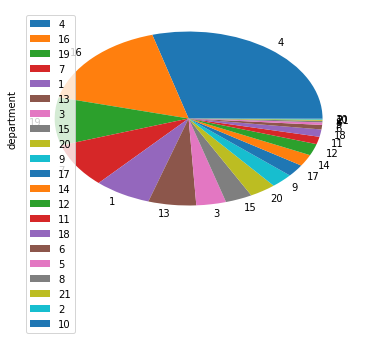

In [271]:
dept_orders.plot.pie(y='times_ordered', label='department')

In [75]:
user_means = {}
user_std = {}
order_sizes = ops.groupby('order_id').size()

# plot number of orders by user vs. average size of those orders
for i in tqdm(range(len(user_orders))):
    row = user_orders.iloc[i]   # row is list of orders a user has made
    user = user_orders.index[i]
    order_sizes_for_user = []
    for order in row:
        # print(order)
        try:
            order_sizes_for_user.append(order_sizes[order])
        except KeyError:
            continue
    user_means[user] = pd.np.mean(order_sizes_for_user)
    user_std[user] = pd.np.std(order_sizes_for_user)

100%|██████████| 25000/25000 [00:10<00:00, 2416.02it/s]


In [69]:
user_orders[2]

array([2168274, 1501582, 1901567,  738281, 1673511, 1199898, 3194192,
        788338, 1718559, 1447487, 1402090, 3186735, 3268552,  839880,
       1492625])

In [103]:
users = orders.groupby('user_id').size()

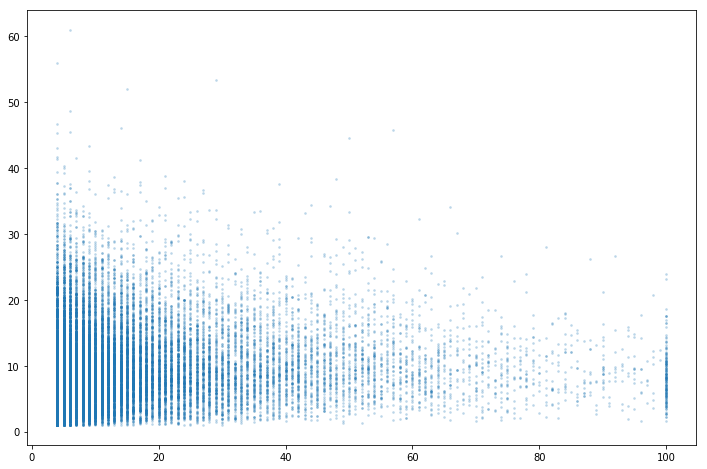

In [222]:
plt.figure(figsize=(12,8))
ax = plt.scatter(x=users, y=user_mean, s=3, alpha=.2)
ax.set_label('users')

Text(0.5,0,'Day of week')

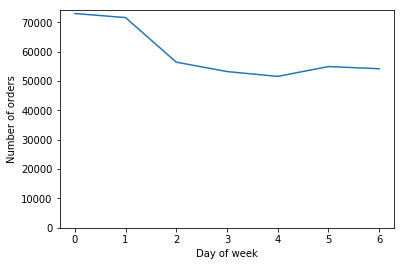

In [117]:
ax = orders.groupby('order_dow').size().plot()
ax.set_ybound(0)
ax.set_ylabel('Number of orders')
ax.set_xlabel('Day of week')

[Text(0,0,'0'),
 Text(0,0,'1'),
 Text(0,0,'2'),
 Text(0,0,'3'),
 Text(0,0,'4'),
 Text(0,0,'5'),
 Text(0,0,'6'),
 Text(0,0,'7')]

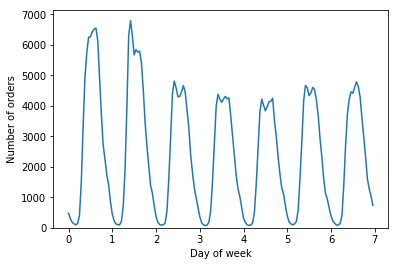

In [119]:
ax = orders.groupby(['order_dow', 'order_hour_of_day']).size().plot()
ax.set_ybound(0)
ax.set_ylabel('Number of orders')
ax.set_xlabel('Day of week')
ax.set_xticks([24 * i for i in range(8)])
ax.set_xticklabels(range(8))

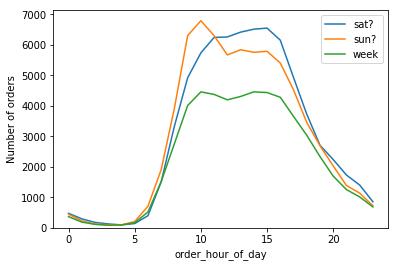

In [120]:

ax = (orders[orders.order_dow == 0].groupby('order_hour_of_day').size()).plot(label='sat?')
ax = (orders[orders.order_dow == 1].groupby('order_hour_of_day').size()).plot(label='sun?')
ax.set_ylabel('Number of orders')
ax.set_xlabel('hour')

ax = (orders[orders.order_dow.isin([2,3,4,5,6])].groupby('order_hour_of_day').size()/5).plot(label='week')
ax.set_ybound(0)
ax.legend()

# Interesting features of time distribution: 

- weekday lunch trough
- first two days must be Sat/Sun? 5 vs. 2

In [ ]:
ops